# Preprocessing
## Read Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from processing.preprocessing import impute_missing, regress_confounders, z_score
from processing.factoranalysis import calculate_scores

In [10]:
df = pd.read_excel("../data/DB_EPP-SCZ_Mikkel Schöttner_20230119_OK.xlsx", sheet_name=1, index_col=0)
df.sort_values("Cohort", inplace=True) # sort by cohort
df['Cohort'].value_counts() # how many in each cohort?

EPP    169
SCZ     63
Name: Cohort, dtype: int64

There are some duplicate entries. We will keep the ones in the schizophrenia cohort, as there are less patients here.

In [6]:
keep = df.index.duplicated(keep="last")==False # True for first duplicate
df = df[keep] # only keep non-duplicates and second occurance of duplicates (schizophrenia cohort)
pd.set_option('display.max_columns', None)
df.describe(include="all")


,Cohort,Diagnostic_1,Age Clinical Eval,Age Neurocognition Eval,Age MRI,MRI Type scan,MRI done,Age Psychosis Threshold,Duration Of Psychosis days,Duration of Untreated Psychosis,CPZ equivalent,Gender,Laterality,Years of Education,Modified Vocation Code Index,Modified Location Code Index,Tobacco Cigarettes per Day,CMRS Cannabis,CMRS Cocaine,CMRS Hallucinogenics,CMRS Opiates,CMRS PCP,CMRS Stimulants,CMRS Sedatives Hypnotic Anxiolytics,CMRS non prescription drugs,CMRS other,CMRS Alcohol,Clinical Global Impression,Global Assessment of Functioning,Social and Occupational Functioning Assessment,PANSS WALLWORK POSITIVE,PANSS WALLWORK NEGATIVE,PANSS WALLWORK DISORGANIZED,PANSS WALLWORK EXCITED,PANSS WALLWORK DEPRESSED,MADRS Depression,YMRS Mania,ROSENBERG Self-Esteem,WHOQOL Domain 1,WHOQOL Domain 2,WHOQOL Domain 3,WHOQOL Domain 4,Premorbid Adjustment Scale,PSQI,CTQ Emotional Abuse,CTA Emotional Neglect,CTQ Physical Abuse,CTQ Physical Neglect,CTQ Sexual Abuse,Trail Making Test A,Trail Making Test B,Brief Asessment of Cognition in Schizophrenia,Hopkins Verbal Learning Test,Wechsler Memory Scale - Spatial Span,Letter-Number Span,Neuropsychological Assessment Battery - Mazes,Brief Visuospatial Memory Test,Verbal Fluency,Continuous Performance Test,WAIS-III Vocabulary,WAIS-III Matrix Reasoning,Reading the Mind in the Eyes Test,Multimorph Task - Sensitivity,Multimorph Task - Accuracy
count,226,224,223.000000,150.000000,158.000000,151,226,223.000000,220.000000,161.000000,222.000000,226,180,173.000000,164,163,155.000000,159.000000,159.000000,159.000000,159.000000,159.0,159.000000,159.0,159.000000,159.000000,159.000000,161.000000,158.000000,158.000000,222.000000,222.000000,222.000000,222.000000,222.000000,157.000000,159.000000,137.000000,99.000000,99.000000,99.000000,99.000000,94.000000,49.000000,90.000000,91.000000,90.000000,91.000000,89.000000,162.000000,70.000000,162.000000,159.000000,161.000000,156.000000,162.000000,162.000000,160.000000,138.000000,85.000000,100.000000,65.000000,61.000000,61.000000
unique,2,16,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,2,3,NaN,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,EPP,Schizophrénie,NaN,NaN,NaN,Prisma,yes,NaN,NaN,NaN,NaN,male,right,NaN,sick leave,alone or with friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,164,145,NaN,NaN,NaN,76,157,NaN,NaN,NaN,NaN,169,161,NaN,41,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,28.009841,27.647288,28.950806,NaN,NaN,23.343596,1626.818182,366.546584,327.386230,NaN,NaN,12.687861,NaN,NaN,9.438710,1.396226,1.056604,1.006289,1.012579,1.0,1.006289,1.0,1.012579,1.006289,1.704403,3.714286,55.341772,56.411392,7.198198,14.666667,5.963964,6.013514,8.270270,13.133758,3.018868,27.766423,23.949495,19.464646,9.454545,27.919192,23.329787,23.693878,9.800000,12.934066,6.755556,8.406593,6.303371,37.572469,69.256143,47.765432,24.974843,16.832298,14.621795,19.925926,25.259259,21.700000,2.436705,34.141176,19.220000,24.569231,0.880618,0.770036
std,NaN,NaN,8.523748,8.491806,9.375264,NaN,NaN,5.793087,2283.433395,643.886878,264.788666,NaN,NaN,3.349023,NaN,NaN,10.105344,0.729304,0.302841,0.079305,0.158610,0.0,0.079305,0.0,0.158610,0.079305,0.661351,0.958049,11.753179,11.885939,3.170337,5.658187,2.166917,2.280112,3.089746,8.518528,3.755960,6.380419,4.924685,4.895465,2.800411,6.259159,7.583781,4.651183,4.449972,4.386348,3.163383,2.886667,3.465428,20.332538,30.398786,11.493203,4.824712,3.094826,3.327971,6.145802,7.497043,6.559644,0.690630,9.897273,4.858773,4.311936,0.105125,0.092286
min,NaN,NaN,15.498630,15.539726,15.652055,NaN,NaN,13.008219,51.0

In [7]:
pd.reset_option("max_columns")

## Missing Data

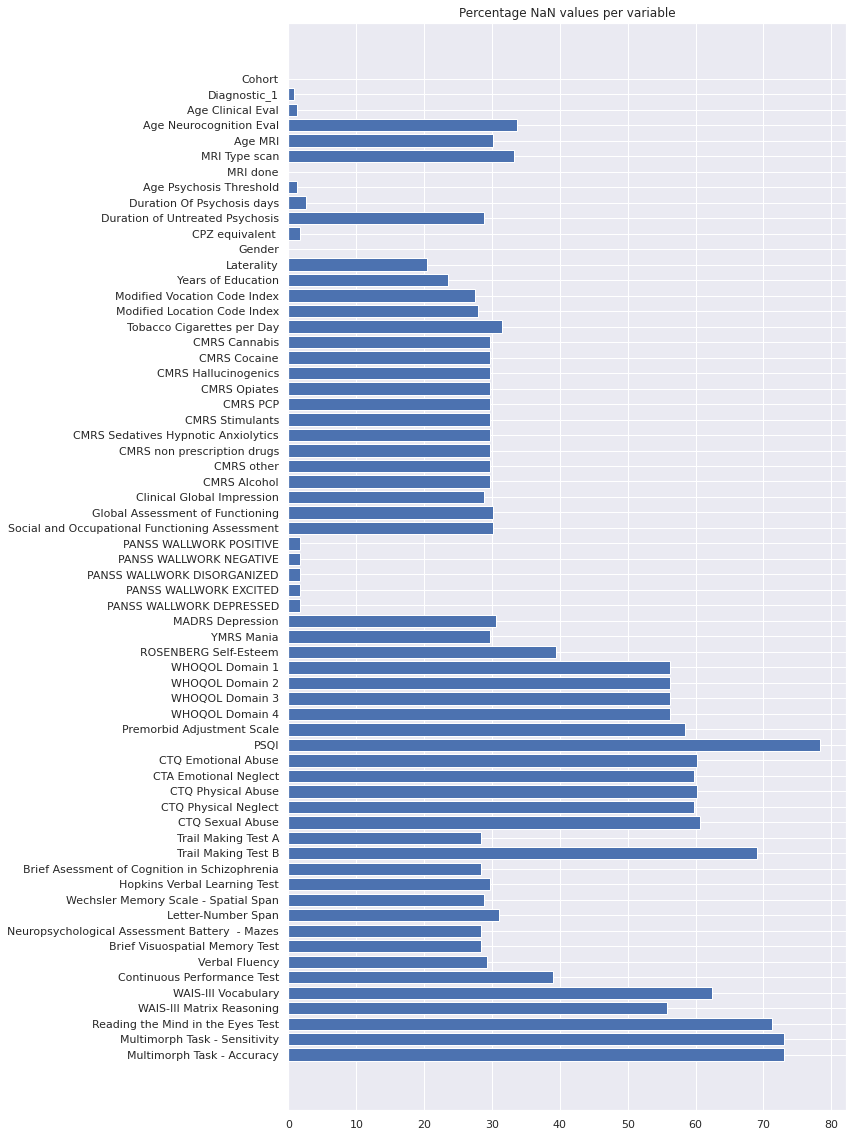

In [8]:
percent_missing_var = df.isnull().sum() * 100 / len(df)
percent_missing_sub = df.isnull().sum(axis=1) * 100 / len(df.columns)
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(percent_missing_var.index, percent_missing_var)
ax.invert_yaxis()
ax.set_title("Percentage NaN values per variable")
plt.show()

For many variables there is a lot of missing data. Let's look at this subject-wise. Is the missingness distributed equally or are there some subjects that are missing a lot, and others that are almost complete?

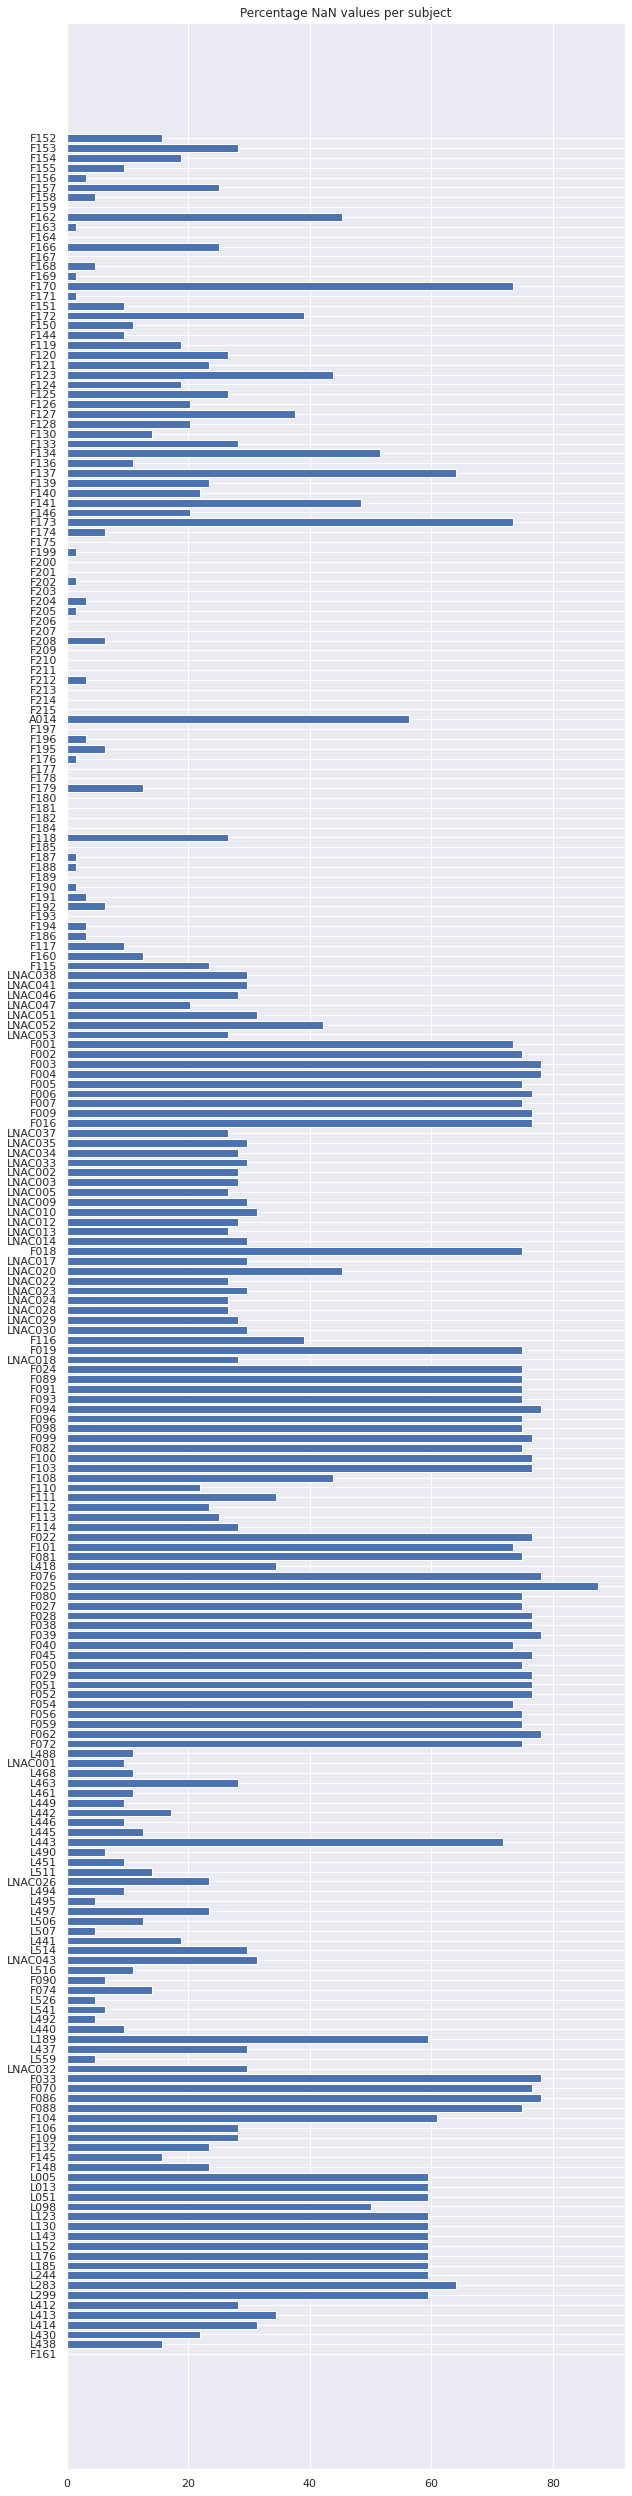

In [11]:
fig, ax = plt.subplots(figsize=(10,45))
ax.barh(percent_missing_sub.index, percent_missing_sub)
ax.invert_yaxis()
ax.set_title("Percentage NaN values per subject")
plt.show()

Some subjects are missing like 60-80 %, some like 30 %. Maybe we have more variables with reasonable amounts of missingness if we exclude the subjects with more than 50 % missing data?

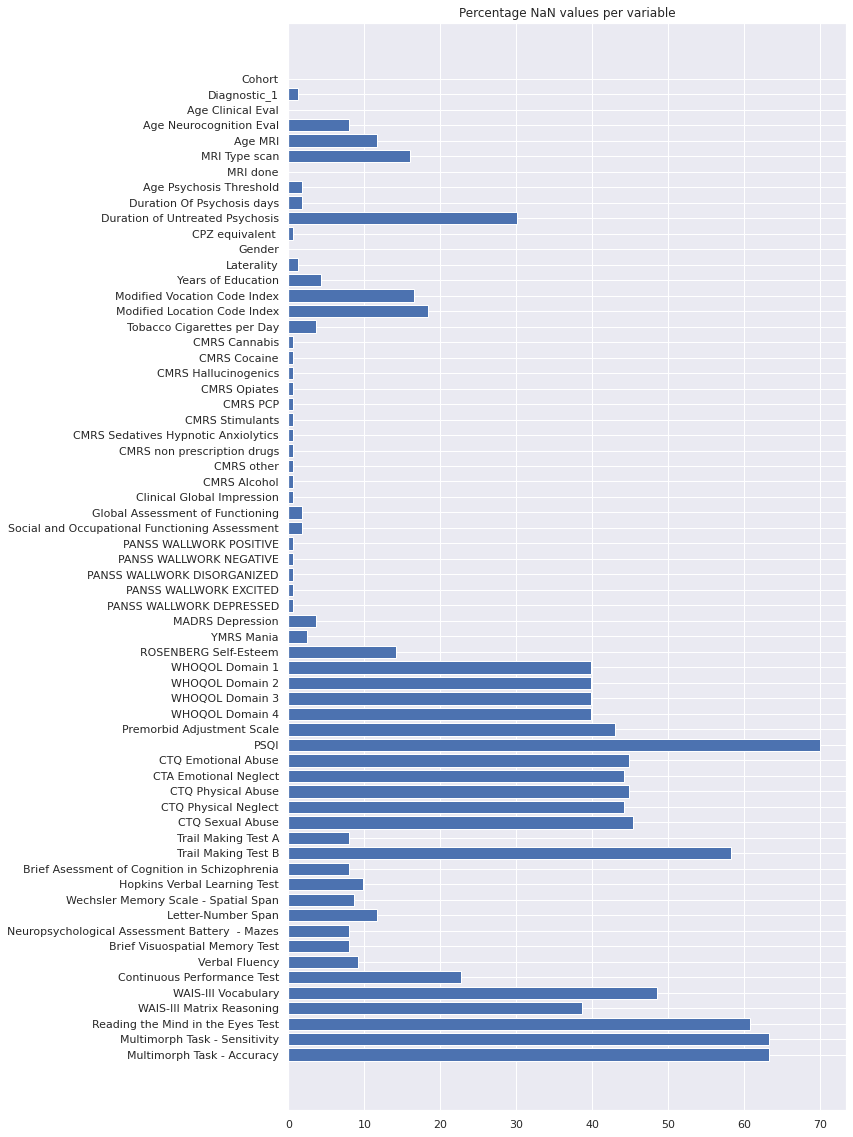

In [12]:
subjects_include = percent_missing_sub[percent_missing_sub < 50].index
df_include = df.loc[subjects_include,:].copy()
percent_missing_var_include = df_include.isnull().sum() * 100 / len(df_include)
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(percent_missing_var_include.index, percent_missing_var_include)
ax.invert_yaxis()
ax.set_title("Percentage NaN values per variable")
plt.show()

This looks a lot better. With a threshold of 20 % missing, we should retain a reasonable number of variables for further analysis.

In [13]:
vars_include = list(percent_missing_var_include[percent_missing_var_include < 20].index)
df_include_vars = df_include[vars_include].copy()

## Distributions

Let's separate the socio-demographic data from the behavioral scores.

In [20]:
df_demo = df_include_vars.loc[:,:"Years of Education"].copy()
df_behavior = df_include_vars.loc[:,"Tobacco Cigarettes per Day":].copy()

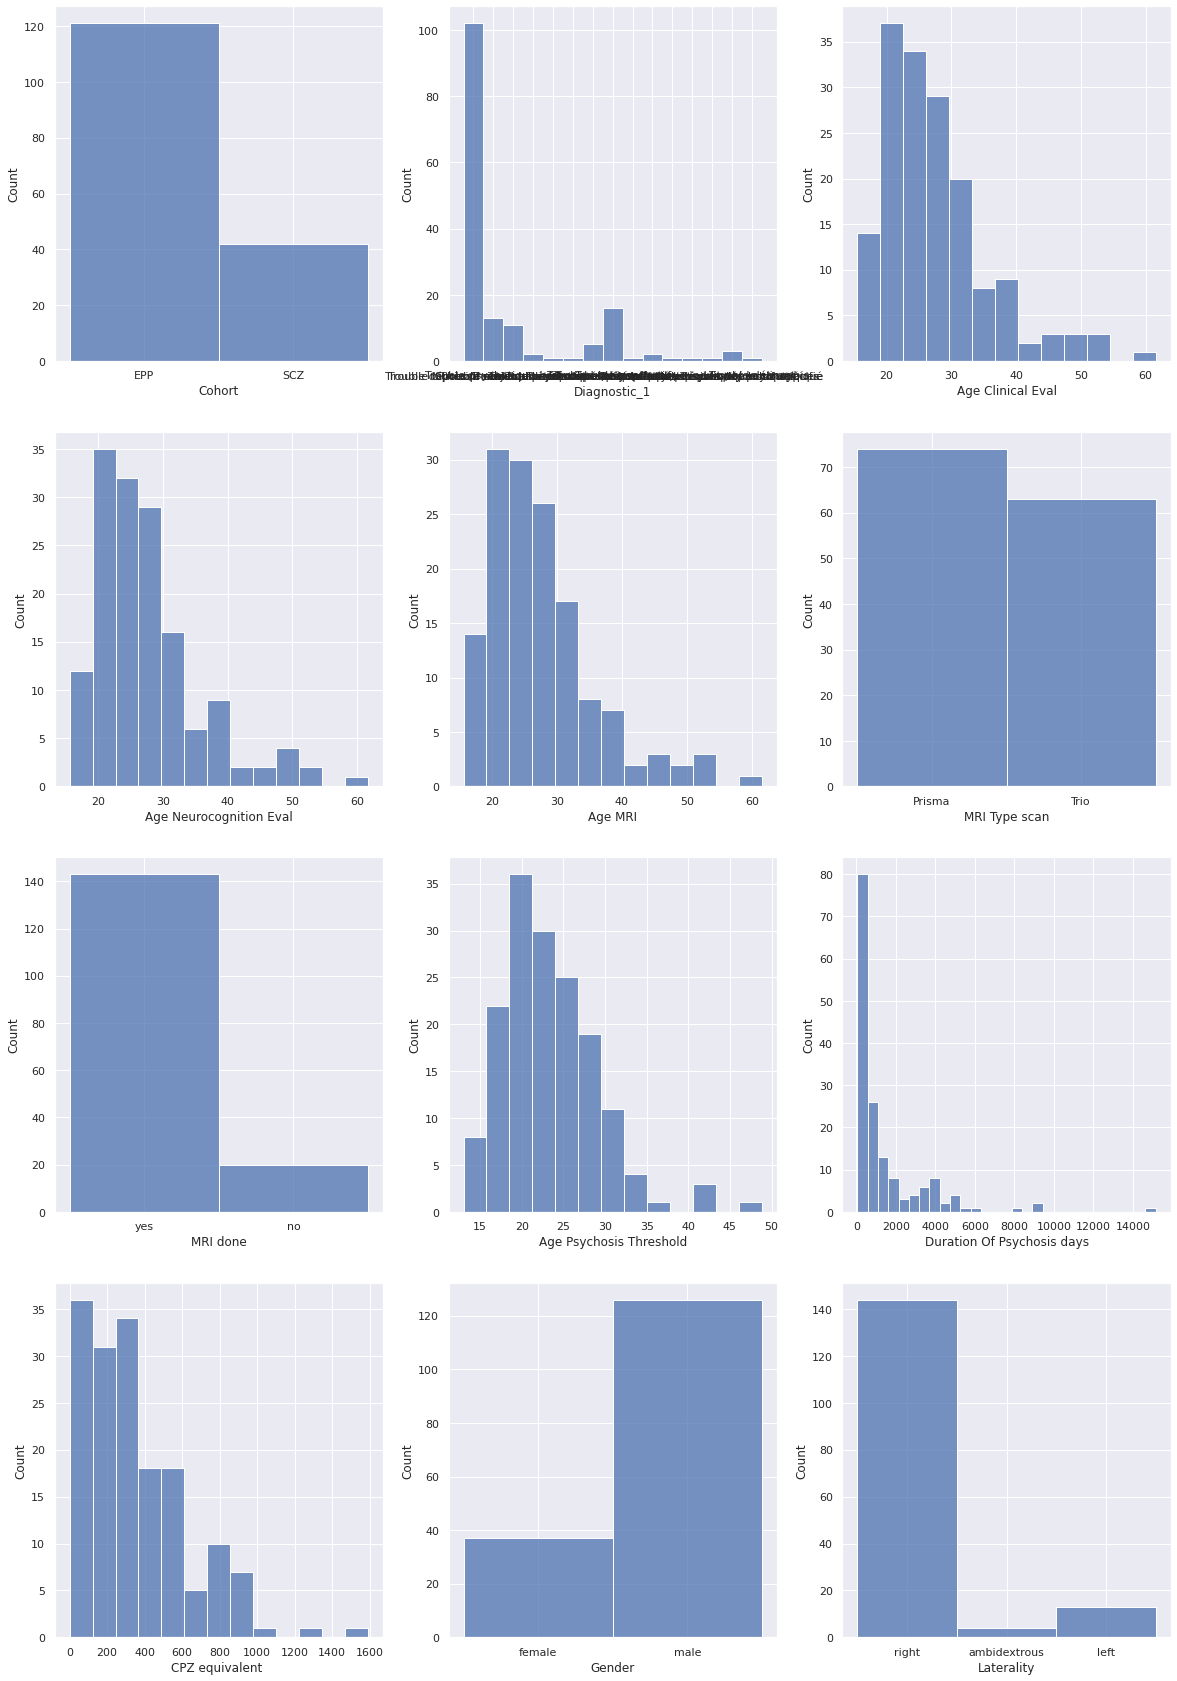

In [21]:
fig, axs = plt.subplots(4, 3, figsize=(20,30))
axs = axs.flatten()
for col, ax in zip(df_demo.columns, axs):
    sns.histplot(df_demo[col], ax=ax)

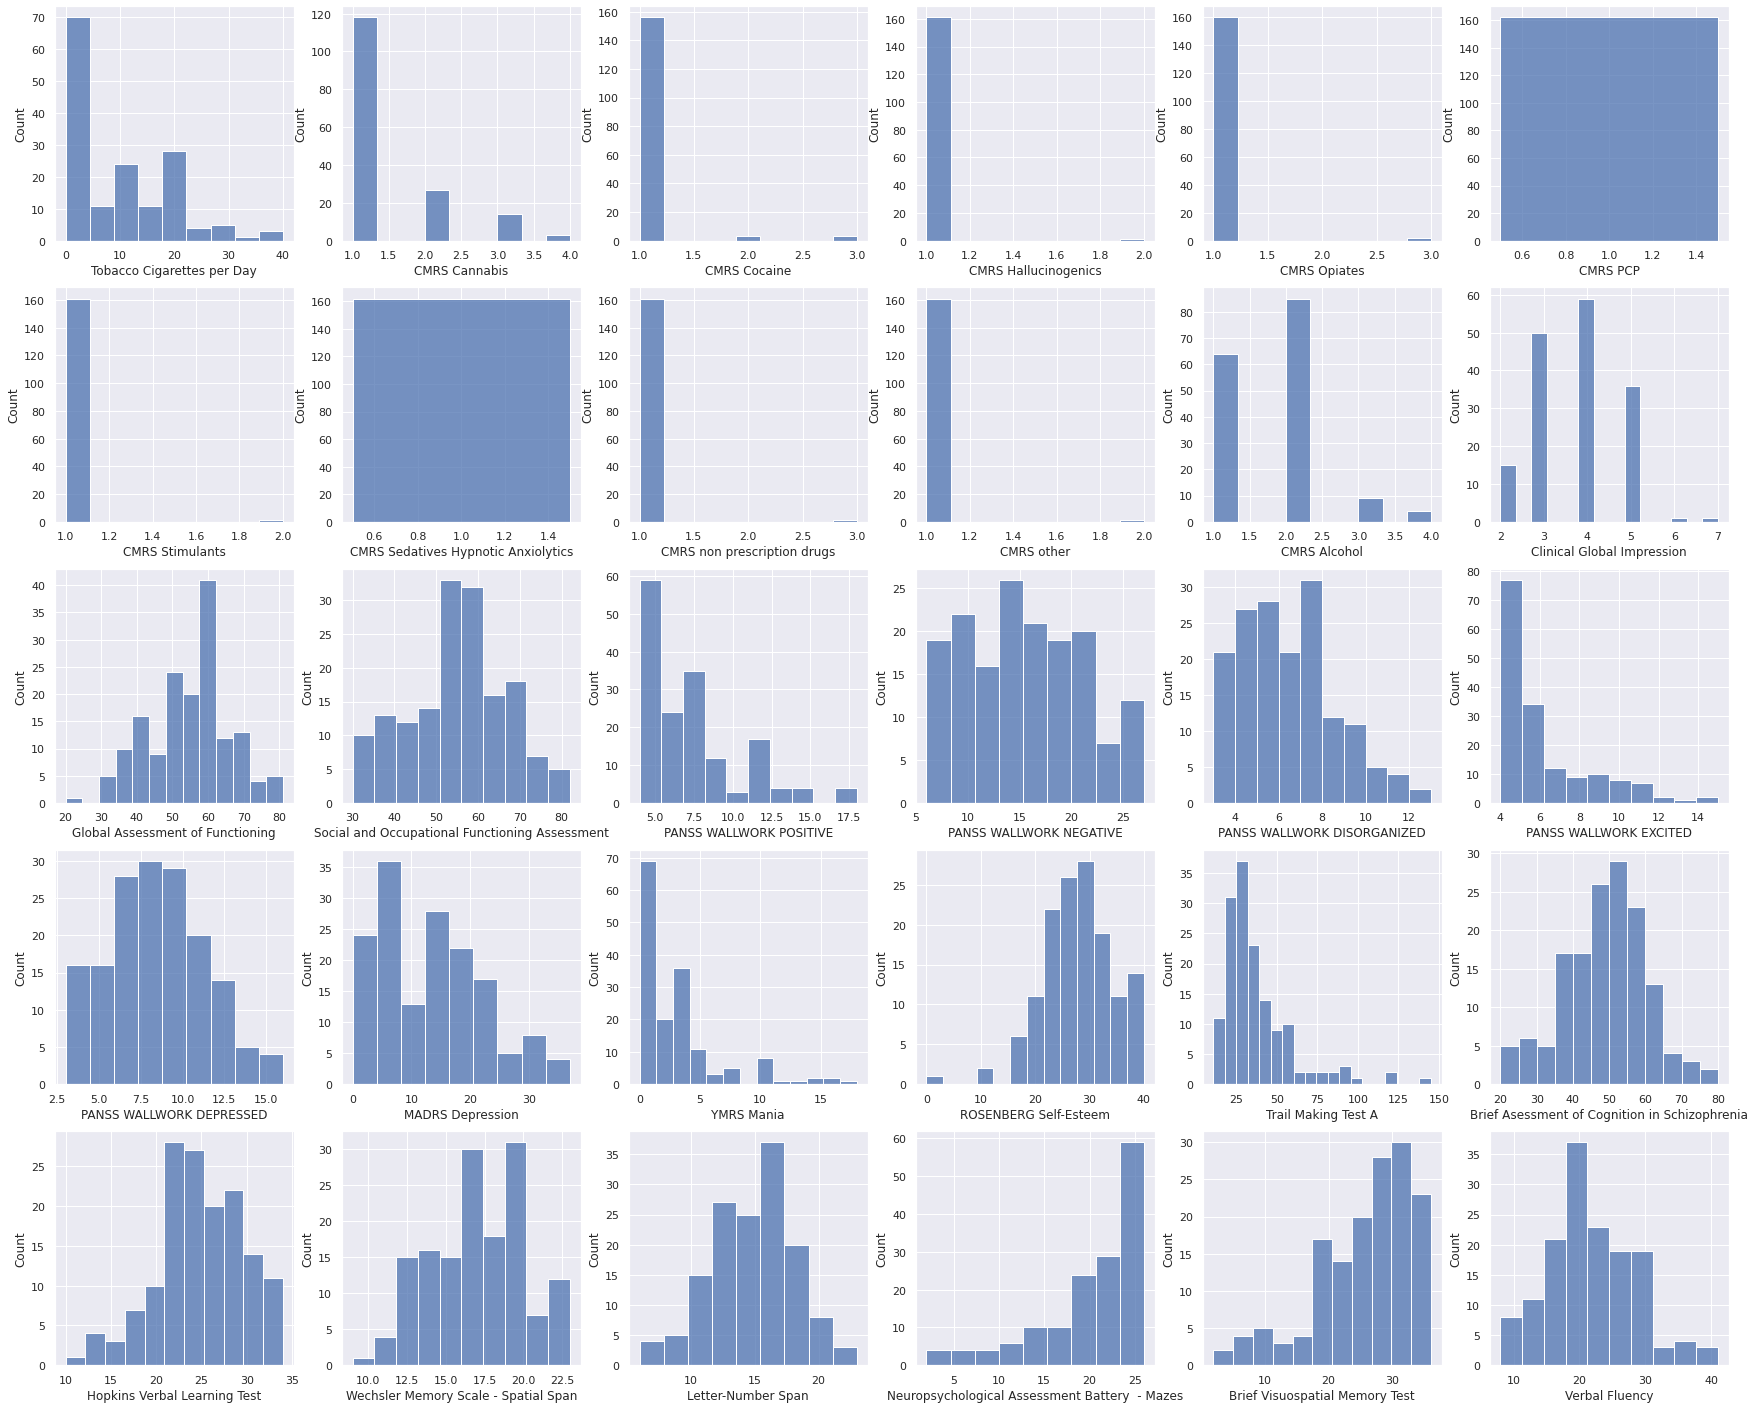

In [22]:
fig, axs = plt.subplots(5, 6, figsize=(30,25))
axs = axs.flatten()
for col, ax in zip(df_behavior.columns, axs):
    sns.histplot(df_behavior[col], ax=ax)

It only makes sense to retain variables with meaningful amounts of variation. This is not the case for some of the drug-related questionnaires: Cocaine, Hallucinogenics, Opiates, PCP, Stimulants, Sedatives/Hypnotics/Anxiolytics, Non Prescription Drugs, and Other should thus be excluded.

<AxesSubplot:>

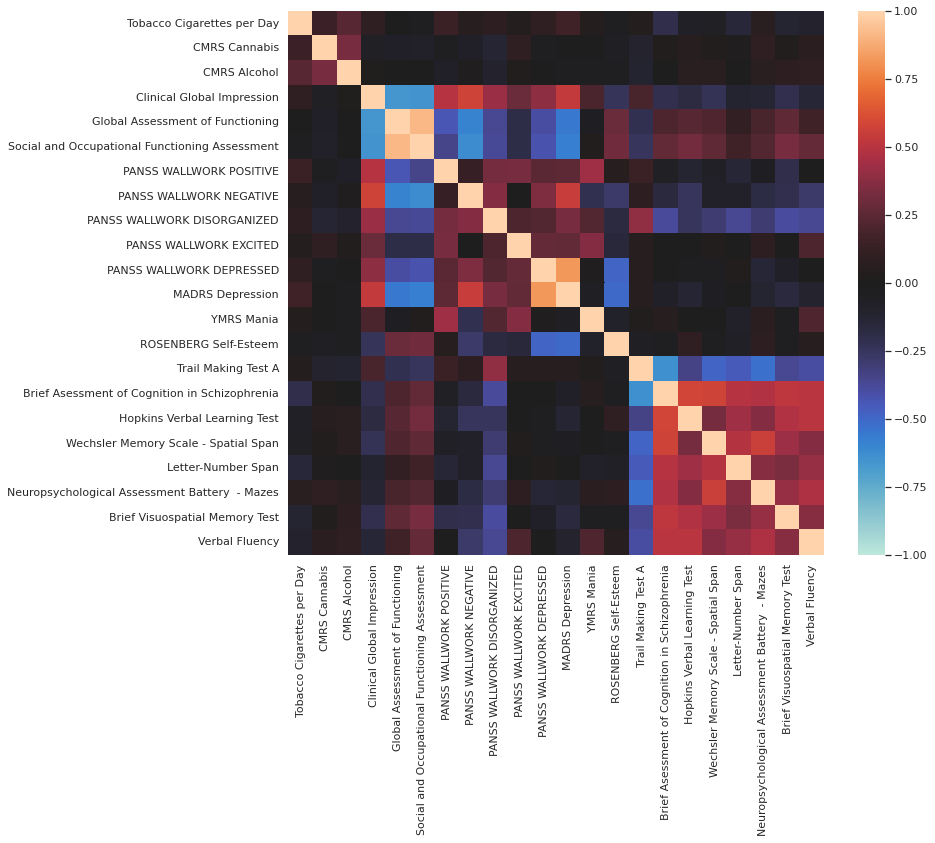

In [24]:
df_behavior_include = df_behavior.loc[:, ~df_behavior.columns.isin(['CMRS Cocaine',
       'CMRS Hallucinogenics', 'CMRS Opiates', 'CMRS PCP', 'CMRS Stimulants',
       'CMRS Sedatives Hypnotic Anxiolytics', 'CMRS non prescription drugs',
       'CMRS other'])].copy()
plt.subplots(figsize=(12,10))
sns.heatmap(df_behavior_include.corr(), vmin=-1, vmax=1, center=0)

From visual inspection, the data set seems suitable for a factor analysis. There are correlations between the variables, and already three clusters of variables can be made out: The substance use items, the clinical items, and the cognition items.

## Imputation

There are still some missing values, which we will impute using the MICE algorithm.

In [25]:
df_behavior_imputed = impute_missing(df_behavior_include)

## Regressing Confounders

Regressing out age and gender.

In [26]:
df_behavior_regressed = regress_confounders(df=df_behavior_imputed, age=df_demo["Age Clinical Eval"].copy(), gender=df_demo["Gender"].copy())

## Z-Score Data

Z-score data.

In [27]:
df_behavior_z = z_score(df_behavior_regressed)

## Invert Trailmaking

Invert the trailmaking task such that larger values = better.

In [28]:
df_behavior_z["Trail Making Test A"] = df_behavior_z["Trail Making Test A"]*-1

## Save Data

In [29]:
# save data as csv
df_behavior_z.to_csv("/home/localadmin/psychosis_dimensions/data/behavior.csv")
df_demo.loc[df_behavior_z.index].to_csv("/home/localadmin/psychosis_dimensions/data/demo.csv")